In [0]:
# { run: "auto" }

!pip -q install parfit

import sys
from google.colab import drive

print("\nGoogle Drive File Stream Authentication\n")
drive.mount('/content/drive',force_remount=True)
sys.path.append('/content/drive/My Drive')
sys.path.append('/content/drive/My Drive/Colab Notebooks/Notebooks')

from lib.Config import *
from lib.MachineLearningController import *

def saveDocument(fileName):
  !jupyter nbconvert --log-level 0 --output {fileName} --output-dir='drive/My Drive/Colab Notebooks/Documents' "drive/My Drive/Colab Notebooks/Notebooks/MachineLearning.ipynb"
  print("File saved to .../Colab Notebooks/Documents/{}.html".format(fileName))

#@markdown First time RUN THIS CELL
#@markdown
#@markdown Separate datasetsToLoad and datasetsToMerge names with COMMA (,)
#@markdown
#@markdown Enter datasetsToLoad and datasetsToMerge names WITHOUT file extension
datasetsToLoad = 'dataset_4_OHE' #@param {type:"string"}
datasetsToMerge = '' #@param {type:"string"}
merge = False  #@param {type:"boolean"}
selectTopFeatures = True  #@param {type:"boolean"}
OHE = True  #@param {type:"boolean"}
#@markdown Set machine learning mode prefix and the notebook name
modelPrefix = '' #@param {type:"string"}
documentName = 'dataset_4_OHE_TOPF_T' #@param {type:"string"}

Loading datasets...

Datasets:
dataset_4_OHE
Rows: 440042
Columns: 218


To access dataset use datasets['datasetName']

Transforming datasets...

Train set size: 281626
Validation set size: 70407
Test set size: 88009

Analyzing datasets...

dataset_4_OHE
Total rows: 440042
Total features: 218
Normal traffic: 351148 (79.8 %)
Attack traffic: 88894 (20.2 %)





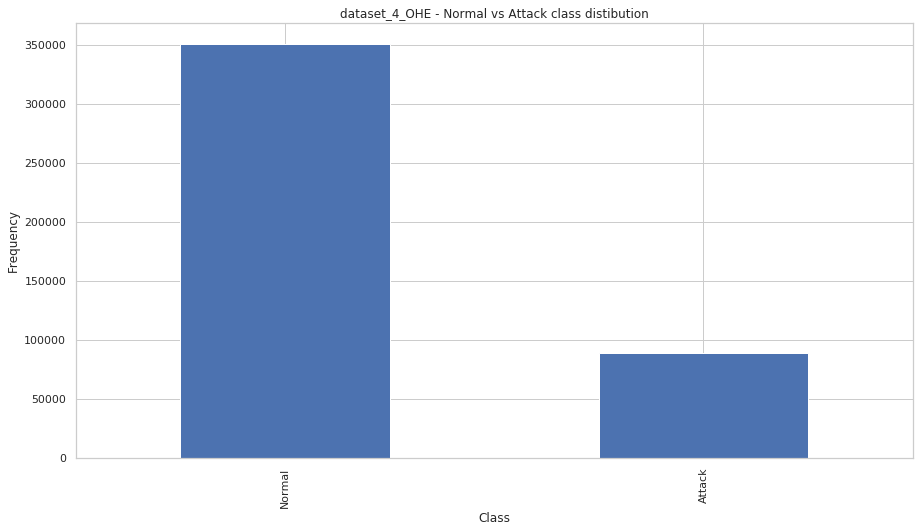

In [2]:
print("Loading datasets...\n")
datasetsToLoad = parsePreprocessedDatasetsNames(datasetsToLoad)
loadPreprocessedDatasets(dataset_preprocessed_path,datasetsToLoad)

if merge and (len(datasetsToLoad) > 1) and (len(list(datasetsToMerge)) >= 2):
  print("Merging datasets...\n")
  datasetsToMerge = parseDatasetsToMergeNames(datasetsToMerge)
  dataset = mergeDatasets(datasetsToMerge)
  title = "Merged dataset"
else:
  df = list(datasets)
  title = df[0]
  dataset = datasets[df[0]]

print("Transforming datasets...\n")
X_train, y_train, X_valid, y_valid, X_test, y_test = splitDataset(dataset)

print("Analyzing datasets...\n")
analyzeDataset(dataset, title)
if not OHE:
  getCorelationMatrix(X_train, title)

In [0]:
# ---> Logistic Regression <---

In [0]:
logisticRegression_model = LogisticRegression()
rfe = RFE(logisticRegression_model, n_features_to_select=None, step=8, verbose=1)
rfe.fit(X_train, y_train)

selected_columns=[]
columns = X_train.columns
ranked_columns = rfe.support_

for i in range(len(ranked_columns)):
  if ranked_columns[i] == True:
    selected_columns.append(columns[i])

print("\nNumber of selected columns: {}\n".format(len(selected_columns)))
selected_columns

Fitting estimator with 217 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 209 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 201 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 193 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [0]:
X_train_logreg=X_train[selected_columns]
X_valid_logreg=X_valid[selected_columns]
X_test_logreg=X_test[selected_columns]

try:
  logReg_selectedAttributes=sm.Logit(y_train,X_train_logreg)
  logisticRegression_selectedAttributes=logReg_selectedAttributes.fit()
except np.linalg.LinAlgError as err:
  print("\nIndependent attributes are correlated, which lead to singular matrix.\n"+
        "Remove any attribute that seems that would  be perfectly corelated.\n")
  #selected_columns = ['srcip', 'dstip', 'dsport', 'proto', 'state', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'Dload', 'Dpkts', 'Dintpkt', 'synack', 'ct_state_ttl', 'ct_flw_http_mthd', 'ct_ftp_cmd', 'ct_srv_dst', 'ct_dst_sport_ltm', 'ct_dst_src_ltm']
  printArray(selected_columns)
  #@markdown Enter index number of the item, which you want to remove and re-run the code cell
  indexToRemove = -1 #@param {type:"integer"}
  removeItemFromArray(selected_columns,index)

  X_train_logreg=X_train[selected_columns]
  X_valid_logreg=X_valid[selected_columns]
  X_test_logreg=X_test[selected_columns]

  logReg_selectedAttributes=sm.Logit(y_train,X_train_logreg)
  logisticRegression_selectedAttributes=logReg_selectedAttributes.fit()

print(logisticRegression_selectedAttributes.summary2())

In [0]:
params = {'penalty': ['l2'],
         'dual': [False],
         'C':[.005,0.01,1,5],
         'solver': ['lbfgs','saga'],
         'max_iter': [100,500],
         'multi_class': ['ovr','auto'],
         'warm_start': [True,False]}

logisticRegression_model = LogisticRegression()
logisticRegression_gridSearch = GridSearchCV(logisticRegression_model, param_grid = params, cv = 10, n_jobs=-1, verbose=2)

if selectTopFeatures:
  logisticRegression_gridSearch = logisticRegression_gridSearch.fit(X_train_logreg, y_train)
else:
  logisticRegression_gridSearch = logisticRegression_gridSearch.fit(X_train, y_train)

pprint(logisticRegression_gridSearch.best_params_)

In [0]:
logisticRegression_model = LogisticRegression(**logisticRegression_gridSearch.best_params_)

if selectTopFeatures:
  logisticRegression = logisticRegression_model.fit(X_train_logreg, y_train)
  predict(logisticRegression, X_valid_logreg, y_valid,"Validation set prediction")
  predict(logisticRegression, X_test_logreg, y_test,"Test set prediction")
  saveModel(logisticRegression,machineLearningModels_path,modelPrefix+'_LogisticRegression_SelectedFeatures')
else:
  logisticRegression = logisticRegression_model.fit(X_train, y_train)
  predict(logisticRegression, X_valid, y_valid,"Validation set prediction")
  predict(logisticRegression, X_test, y_test,"Test set prediction")
  saveModel(logisticRegression,machineLearningModels_path,modelPrefix+'_LogisticRegression')

In [0]:
# ---> SCV <---

In [0]:
grid = {'alpha': [1e-2, 1e-1, 1e0, 1e1, 1e2],
        'max_iter': [500],
        'loss': ['log', 'modified_huber', 'squared_hinge', 'perceptron'],
        'learning_rate': ['constant', 'invscaling', 'adaptive'],
        'eta0': [0.2],
        'fit_intercept': [True,False],
        'shuffle': [True,False],
        'early_stopping': [True,False],
        'penalty': ['l2','elasticnet'],
        'n_jobs': [-1]}
        
if selectTopFeatures:
  feature_map_nystroem = Nystroem(random_state=0,n_components=10)
  X_train_svc = feature_map_nystroem.fit_transform(X_train)
  X_test_svc = feature_map_nystroem.fit_transform(X_test)
  X_valid_svc = feature_map_nystroem.fit_transform(X_valid)

  paramGrid = ParameterGrid(grid)
  SGDClassifier_model = linear_model.SGDClassifier()
  bestModel_SGDClassifier, bestScore_SGDClassifier, allModels, allScores = pf.bestFit(SGDClassifier_model, paramGrid,
                                                                                      X_train_svc, y_train, X_valid_svc, y_valid, 
                                                                                      metric = roc_auc_score, scoreLabel = 'AUC')
  SGDClassifier_model = bestModel_SGDClassifier
  SGDClassifier = SGDClassifier_model.fit(X_train_svc, y_train)
  predict(SGDClassifier, X_valid_svc, y_valid,"Validation set prediction")
  predict(SGDClassifier, X_test_svc, y_test,"Test set prediction")
  saveModel(SGDClassifier,machineLearningModels_path,modelPrefix+'_SGDClassifier')
else:
  paramGrid = ParameterGrid(grid)
  SGDClassifier_model = linear_model.SGDClassifier()
  bestModel_SGDClassifier, bestScore_SGDClassifier, allModels, allScores = pf.bestFit(SGDClassifier_model, paramGrid,
                                                                                      X_train, y_train, X_valid, y_valid, 
                                                                                      metric = roc_auc_score, scoreLabel = 'AUC')
  SGDClassifier_model = bestModel_SGDClassifier
  SGDClassifier = SGDClassifier_model.fit(X_train, y_train)
  predict(SGDClassifier, X_valid, y_valid,"Validation set prediction")
  predict(SGDClassifier, X_test, y_test,"Test set prediction")
  saveModel(SGDClassifier,machineLearningModels_path,modelPrefix+'_SGDClassifier')

In [0]:
# ---> Decision Tree <---

In [0]:
if OHE:
  decisionTreeModel = DecisionTreeClassifier()
else:
  hyperparameters = TreeBasedModelHyperparameterSelector(X_train, y_train, randomForest=False)
  decisionTreeModel = DecisionTreeClassifier(**hyperparameters)

if selectTopFeatures:
  selected_features = SelectFromModel(decisionTreeModel)
  selected_features.fit(X_train, y_train)
  features = X_train.columns[(selected_features.get_support())]
  X_train_decisionTree = selected_features.transform(X_train)
  X_valid_decisionTree = selected_features.transform(X_valid)
  X_test_decisionTree = selected_features.transform(X_test)
  print("\nSelected features: {}".format(features))

  hyperparameters = TreeBasedModelHyperparameterSelector(X_train_decisionTree, y_train, randomForest=False)
  decisionTreeModel = DecisionTreeClassifier(**hyperparameters)
  decisionTree = decisionTreeModel.fit(X_train_decisionTree, y_train)
  predict(decisionTree, X_valid_decisionTree, y_valid,"Validation set prediction")
  predict(decisionTree, X_test_decisionTree, y_test,"Test set prediction")
  saveModel(decisionTree,machineLearningModels_path,modelPrefix+'_DecisionTree_SelectedFeatures')
else:
  decisionTree = decisionTreeModel.fit(X_train, y_train)
  predict(decisionTree, X_valid, y_valid,"Validation set prediction")
  predict(decisionTree, X_test, y_test,"Test set prediction")
  saveModel(decisionTree,machineLearningModels_path,modelPrefix+'_DecisionTree')

In [0]:
# ---> Random Forest <---

In [0]:
if OHE:
  randomForestModel = RandomForestClassifier()
else:
  hyperparameters = TreeBasedModelHyperparameterSelector_2(X_train, y_train, randomForest=True)
  randomForestModel = RandomForestClassifier(**hyperparameters)

if selectTopFeatures:
  selected_features = SelectFromModel(randomForestModel)
  selected_features.fit(X_train, y_train)
  features = X_train.columns[(selected_features.get_support())]
  X_train_randForest = selected_features.transform(X_train)
  X_test_randForest = selected_features.transform(X_test)
  X_valid_randForest = selected_features.transform(X_valid)
  print("\nSelected features: {}".format(features))

  hyperparameters = TreeBasedModelHyperparameterSelector_2(X_train_randForest, y_train, randomForest=True)
  randomForestModel = RandomForestClassifier(**hyperparameters)
  randomForest = randomForestModel.fit(X_train_randForest, y_train)
  predict(randomForest, X_valid_randForest, y_valid,"Validation set prediction")
  predict(randomForest, X_test_randForest, y_test,"Test set prediction")
  saveModel(randomForest,machineLearningModels_path,modelPrefix+'_RandomForest_SelectedFeatures')
else:
  randomForest = randomForestModel.fit(X_train, y_train)
  predict(randomForest, X_valid, y_valid,"Validation set prediction")
  predict(randomForest, X_test, y_test,"Test set prediction")
  saveModel(randomForest,machineLearningModels_path,modelPrefix+'_RandomForest')

In [0]:
saveDocument(documentName)

In [0]:
'''
# KNN

error = []
range_form = 1
range_to = 20

for i in range(range_form, range_to):
  KNN = KNeighborsClassifier(n_neighbors=i)
  print("Set KNN")
  KNN.fit(X_train, y_train)
  print("Fitted KNN")
  pred_i = KNN.predict(X_test)
  print("Prediction: .lf%%" % pred_i)
  error.append(np.mean(pred_i != y_test))

plt.plot(range(1, 2), error, color='green', marker='o', markerfacecolor='orange', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

KNN = KNeighborsClassifier(n_neighbors=???)
clf = KNN.fit(X_train, y_train)

predict(clf, X_train, y_train, X_test, y_test)
'''

'''
# KBestFeatures

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

KBestFeatures = SelectKBest(score_func=chi2, k=10)
KBestFeatures_fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(KBestFeatures_fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))
'''

'''
# ExtraTreesClassifier

from sklearn.ensemble import ExtraTreesClassifier

extraTreesClassifier_model = ExtraTreesClassifier()
extraTreesClassifier_model.fit(X,y)

feat_importances = pd.Series(extraTreesClassifier_model.feature_importances_, index=X.columns)
nof = 10
topFeatures = feat_importances.nlargest(nof)
print("Selected Top {} Features\n{}".format(nof,topFeatures))

topFeatures.plot(kind='barh')
plt.show()

selectedFeatures = ['srciploc_AU','srciploc_KP','dstiploc_KP','srciploc_JP','state_INT','ct_state_ttl','ct_ftp_cmd','is_ftp_login','ct_flw_http_mthd','ct_srv_src','ct_dst_src_ltm','sttl','dttl','dwin','label']
dataset_selectedFeatures = dataset[selectedFeatures]
'''